IT-2201

Rakhmetulina Asylzhan

Pernebekova Dina

Zhumakan Tomiris


**Body size estimation** - Neural network that estimates clothing sizes based on input image.


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Take a photo
take_photo()


<IPython.core.display.Javascript object>

'photo.jpg'

In [ ]:
from IPython.display import Image

# Display the captured photo
Image('photo.jpg')


# **Loading data**



Set up

In [6]:
import tensorflow as tf
import os

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')


[]

Define image files with appropriate extensions. Images are downloaded from Google Drive. We have 5 folders with size estimetions:

XS https://drive.google.com/drive/folders/1-NUNgcVE8g1o5cm7wzag03eoZSiJes9B

S https://drive.google.com/drive/folders/1RrHkLOl0H74N2vlvBK3HrZpYK4F6gfGB?usp=sharing

M https://drive.google.com/drive/folders/1LUk9VvG3qkTddIDWFtEBCsAhvh9ZGLEy?usp=sharing

L https://drive.google.com/drive/folders/1epi8b6i6CnS0SbMu6iJqzaMuCIAfk8yN?usp=sharing

XL https://drive.google.com/drive/folders/1JXHDRPAnDyr27ZbK2hA488dvG8nGkOOL?usp=sharing

"data_final" folder https://drive.google.com/drive/folders/1gRzIwia7a81miK-cl7pyfUJ9fBLYB2lo?usp=sharing


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import cv2
import imghdr
data_dir = '/content/drive/MyDrive/data_final'
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [8]:
import numpy as np
from matplotlib import pyplot as plt

data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 250 files belonging to 5 classes.


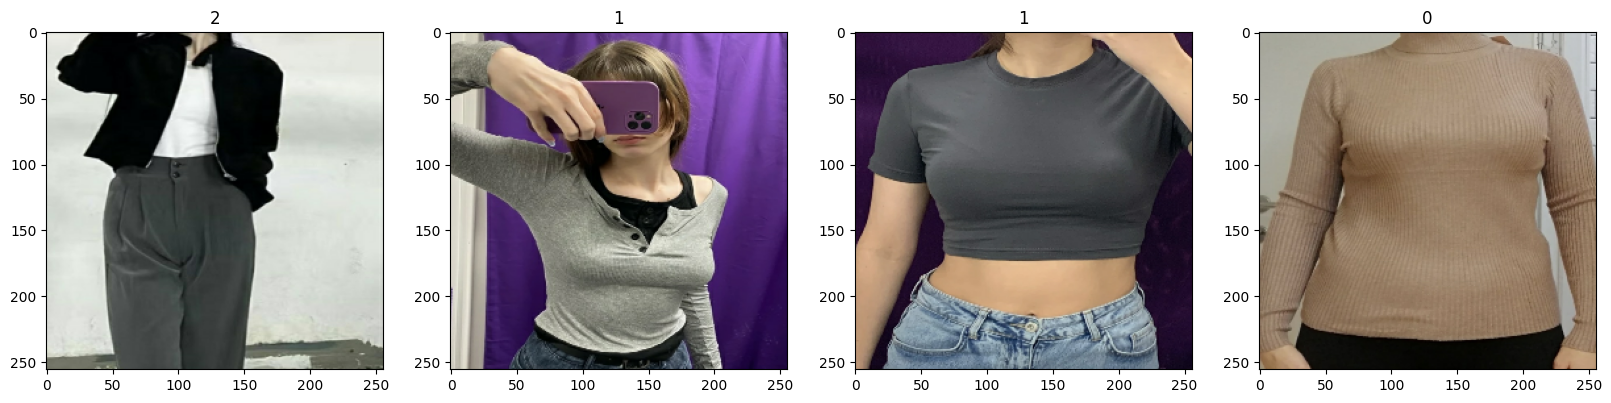

In [13]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,30))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    # 0 -L
    # 1 - M
    # 2 - S
    # 3 - XL
    # 4 - XS

# **Preprocess and split the dataset**

In [14]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[0.7059743 , 0.6549939 , 0.517739  ],
          [0.70980394, 0.6627451 , 0.5137255 ],
          [0.7058824 , 0.65882355, 0.50980395],
          ...,
          [0.32138482, 0.36087623, 0.4       ],
          [0.32138482, 0.36087623, 0.4       ],
          [0.32391137, 0.36330423, 0.40246084]],
 
         [[0.7137255 , 0.6627451 , 0.5254902 ],
          [0.7100873 , 0.6630285 , 0.5140089 ],
          [0.70980394, 0.6627451 , 0.5137255 ],
          ...,
          [0.3137255 , 0.36078432, 0.40784314],
          [0.30982384, 0.35688266, 0.40394148],
          [0.31138277, 0.35984322, 0.4026971 ]],
 
         [[0.70433944, 0.65335906, 0.5161041 ],
          [0.7093111 , 0.6622523 , 0.5132327 ],
          [0.7058824 , 0.65882355, 0.50980395],
          ...,
          [0.31326592, 0.36124387, 0.40876225],
          [0.31329915, 0.36121067, 0.40784314],
          [0.3137255 , 0.36078432, 0.40784314]],
 
         ...,
 
         [[0.61123705, 0.46613902, 0.29358998],
          [0.61726

Here we splitting batches to train, validation and test.

In [15]:
len(data)

8

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [17]:
train_size

5

In [18]:
val_size

2

In [19]:
test_size

1

We can do the same by using tensorflow take() and skip() methods.

In [21]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [22]:
len(train)

5

In [23]:
len(val)

2

In [24]:
len(test)

1

In [25]:
def resize_image(image, label):
    resized_image = tf.image.resize(image, (336, 224))
    return resized_image, label

train_resized = train.map(resize_image)

val_resized = val.map(resize_image)

test_resized = test.map(resize_image)

# **Build model and train**

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [29]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(336,224,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 334, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 167, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 165, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 82, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 52, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 40, 26, 16)        0

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
history = model.fit(train_resized, epochs=20, validation_data=val_resized, callbacks=[early_stopping])

Epoch 1/20
5/5 [==============================] - 19s 3s/step - loss: 2.1699 - accuracy: 0.2438 - val_loss: 1.6138 - val_accuracy: 0.2344
Epoch 2/20
5/5 [==============================] - 15s 3s/step - loss: 1.5847 - accuracy: 0.2125 - val_loss: 1.5425 - val_accuracy: 0.4375
Epoch 3/20
5/5 [==============================] - 17s 3s/step - loss: 1.5396 - accuracy: 0.3875 - val_loss: 1.3893 - val_accuracy: 0.7344
Epoch 4/20
5/5 [==============================] - 14s 3s/step - loss: 1.3522 - accuracy: 0.6313 - val_loss: 1.2233 - val_accuracy: 0.5469
Epoch 5/20
5/5 [==============================] - 18s 4s/step - loss: 1.1818 - accuracy: 0.6062 - val_loss: 0.9740 - val_accuracy: 0.6719
Epoch 6/20
5/5 [==============================] - 14s 3s/step - loss: 0.8708 - accuracy: 0.7625 - val_loss: 0.5986 - val_accuracy: 0.9062
Epoch 7/20
5/5 [==============================] - 15s 3s/step - loss: 0.5977 - accuracy: 0.8562 - val_loss: 0.4849 - val_accuracy: 0.8281
Epoch 8/20
5/5 [==================

# **Plot performance**

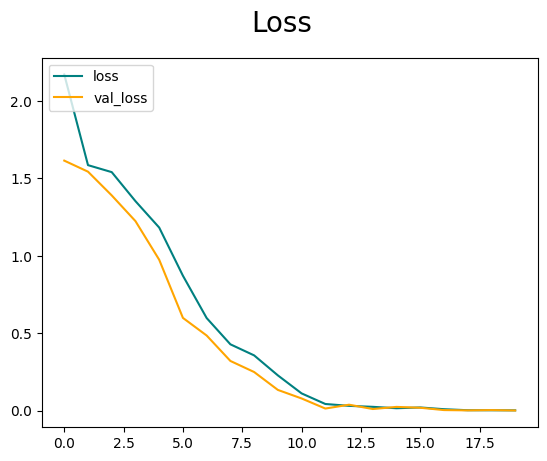

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

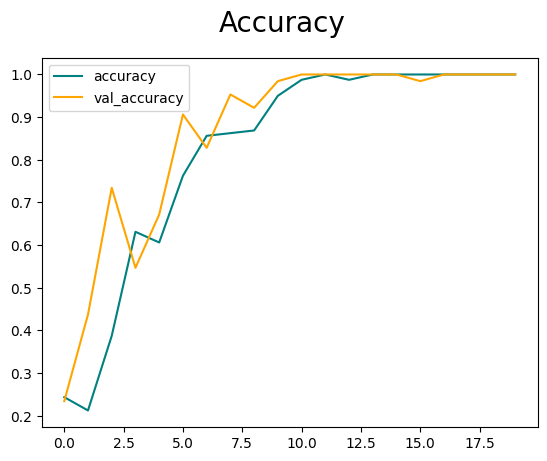

In [40]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# **Test batch**

In [34]:
loss, accuracy = model.evaluate(test_resized)

# Print the test loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 [==============================] - 2s 2s/step - loss: 5.3748e-04 - accuracy: 1.0000
Test Loss: 0.0005374763859435916
Test Accuracy: 1.0


# **Predict image**

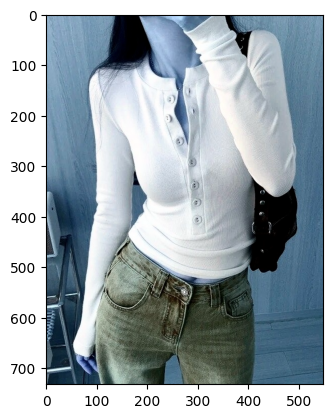

In [64]:
import cv2
image_path = "/content/drive/MyDrive/data_final/XS/IMG_3687.jpg"
img = cv2.imread(image_path)

plt.imshow(img)
plt.show()

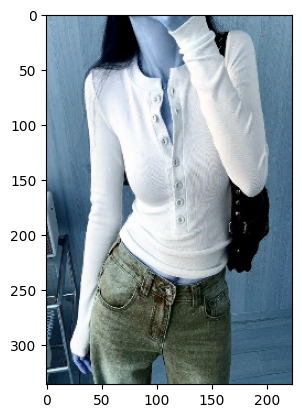

In [65]:
resize = tf.image.resize(img, (336,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [48]:
class_labels = {
    0: 'L',
    1: 'M',
    2: 'S',
    3: 'XL',
    4: 'XS'
}

In [66]:
pre = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 51ms/step


In [67]:
predicted_label_index = np.argmax(pre)
if predicted_label_index in class_labels:
    print("Predicted label:", class_labels[predicted_label_index])
else:
    print("Invalid predicted label index")

actual_label = os.path.basename(os.path.dirname(image_path))

print("Actual label:", actual_label)

Predicted label: XS
Actual label: XS


# **Save the model**

In [57]:
model.save("/content/size.h5")

In [59]:
from google.colab import files
files.download("/content/size.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>